In [1]:
from fastai.vision import *

## Download images from a list of URLs

In [12]:
# Path object for directory containing data
path = Path('data/brands')

# Create subdirectory for pepsi images
folder = 'pepsi'
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)
# Download and save pepsi images
file = 'urls_pepsi.csv'
download_images(path/file, dest, max_pics=200)

# Create subdirectory for coke images
folder = 'coke'
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)
dest = path/folder
# Download and save coke images
file = 'urls_coke.csv'
download_images(path/file, dest, max_pics=200)

In [13]:
classes = ['coke', 'pepsi']

Remove any images that can't be opened:

In [14]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

coke


pepsi


## View data

In [15]:
np.random.seed(42)
data = ImageDataBunch.from_folder(
    path,
    train=".",
    valid_pct=0.2,
    ds_tfms=get_transforms(),
    size=224,
    num_workers=4
).normalize(imagenet_stats)

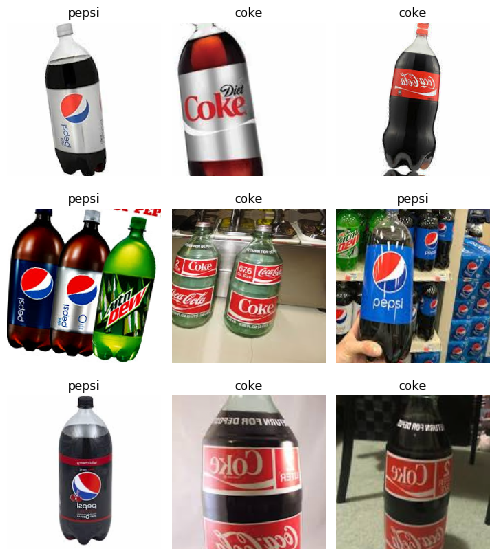

In [17]:
data.show_batch(rows=3, figsize=(7,8))

In [23]:
# Number of images in datasets: training and validation
len(data.train_ds), len(data.valid_ds)

(128, 32)